# Graph SLAM Problem

$\min J(x_i) = x_0^T\Omega_0 x_0 + \sum_t e_t R_t^{-1} e_t  + \sum_t \sum_i \tilde{z}^i_t  Q_t^{-1} \tilde{z}^i_t + \$

$ e_t \equiv x_t - g(u_t, x_{t-1})$ prediction error at time t

$\tilde{z}^i_t \equiv z^i_t - h(x_t, m^i_t)$ measurement error

$\dot{p_x} = v_x$

$\dot{p_y} = v_y$

$x_t = \begin{bmatrix} p_x \\ p_y \end{bmatrix}$
$u_t = \begin{bmatrix} v_x \\ v_y \end{bmatrix}$

$x_t = x_{t-1} + \Delta_t u_t $

$g(u_t, x_t{-1}) = x_{t-1}  + \Delta_t u_t$

Landmarks are points. And our measurement is relative position.

In [9]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import casadi as ca
import slam2d
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


0.6708929538726807
[1.33745135e-36 3.54997466e-02 1.49236018e-02 6.02499949e-02
 1.27074994e-01 1.59793803e-01 1.64702174e-01 1.74769343e-01
 1.76132500e-01 2.09107462e-01 2.12695495e-01 2.11826967e-01
 2.11125317e-01 2.10557848e-01 2.10098551e-01 2.09726591e-01
 2.09425213e-01 2.09180918e-01 2.08982812e-01 2.09046068e-01
 2.10328463e-01 2.13677694e-01 2.26355170e-01 2.26265743e-01
 2.26194385e-01 2.26137395e-01 2.26091834e-01 2.26055369e-01
 2.26026146e-01 2.26002693e-01 2.31050100e-01 2.44944351e-01
 3.58418699e-01 3.34874950e-01 3.32172088e-01 3.52877035e-01
 3.82477398e-01 3.82323181e-01 3.82220977e-01 3.82138247e-01
 3.82065793e-01 3.82000319e-01 3.81940348e-01 3.81885048e-01
 3.81833852e-01 3.81786320e-01 3.81742094e-01 3.81700868e-01
 3.81662378e-01 3.81626395e-01 3.81592718e-01 3.81561167e-01
 3.81531584e-01 3.81503824e-01 3.81477761e-01 3.81453276e-01
 3.81430264e-01 3.81408627e-01 3.81388277e-01 3.81369131e-01]


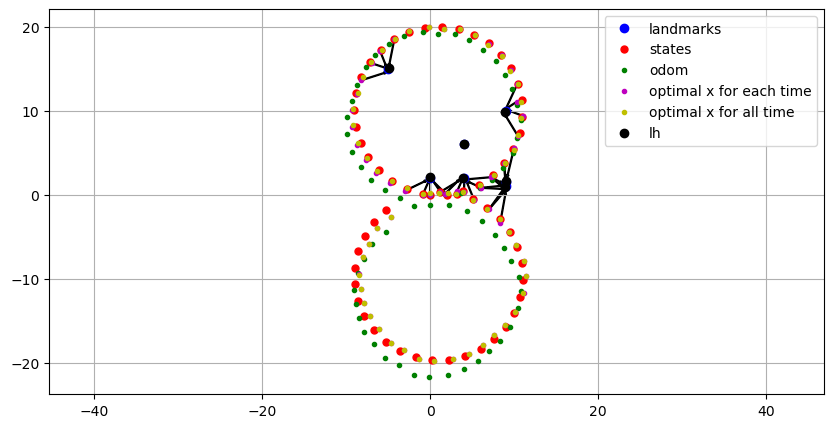

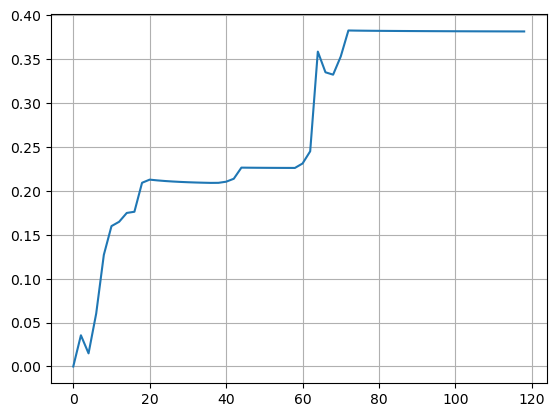

In [17]:
noise={
    'odom_std': 0.1,
    'bearing_std': 0,
    'range_std': 0.05,
    'odom_bx_bias': 0,
    'odom_by_bias': 0
}

plt.figure(figsize=(10, 5))

t0 = time.time()

sim = slam2d.simulate(noise=noise, plot=True, tf=120);

tf =  time.time() - t0
print(tf)

print(sim['hist']['J'])

plt.figure()
plt.plot(sim['hist']['t'], sim['hist']['J'][:])
plt.grid()

In [3]:
float(sim['optim']['f'])

0.0

In [4]:
print(sim['hist']['lh'])

[[[ 0.   2. ]
  [ 4.   6. ]
  [ 9.   1. ]
  [ 4.   2. ]
  [ 9.   1.5]
  [ 9.  10. ]
  [-5.  15. ]]

 [[ 0.   2. ]
  [ 4.   6. ]
  [ 9.   1. ]
  [ 4.   2. ]
  [ 9.   1.5]
  [ 9.  10. ]
  [-5.  15. ]]

 [[ 0.   2. ]
  [ 4.   6. ]
  [ 9.   1. ]
  [ 4.   2. ]
  [ 9.   1.5]
  [ 9.  10. ]
  [-5.  15. ]]

 [[ 0.   2. ]
  [ 4.   6. ]
  [ 9.   1. ]
  [ 4.   2. ]
  [ 9.   1.5]
  [ 9.  10. ]
  [-5.  15. ]]

 [[ 0.   2. ]
  [ 4.   6. ]
  [ 9.   1. ]
  [ 4.   2. ]
  [ 9.   1.5]
  [ 9.  10. ]
  [-5.  15. ]]

 [[ 0.   2. ]
  [ 4.   6. ]
  [ 9.   1. ]
  [ 4.   2. ]
  [ 9.   1.5]
  [ 9.  10. ]
  [-5.  15. ]]

 [[ 0.   2. ]
  [ 4.   6. ]
  [ 9.   1. ]
  [ 4.   2. ]
  [ 9.   1.5]
  [ 9.  10. ]
  [-5.  15. ]]

 [[ 0.   2. ]
  [ 4.   6. ]
  [ 9.   1. ]
  [ 4.   2. ]
  [ 9.   1.5]
  [ 9.  10. ]
  [-5.  15. ]]

 [[ 0.   2. ]
  [ 4.   6. ]
  [ 9.   1. ]
  [ 4.   2. ]
  [ 9.   1.5]
  [ 9.  10. ]
  [-5.  15. ]]

 [[ 0.   2. ]
  [ 4.   6. ]
  [ 9.   1. ]
  [ 4.   2. ]
  [ 9.   1.5]
  [ 9.  10. ]
  [-5.  15. ]]]


In [5]:
sim['optim'].keys()

dict_keys(['f', 'g', 'lam_g', 'lam_p', 'lam_x', 'x'])

In [6]:
# data from sim
odom = sim['hist']['odom']
l = sim['landmarks']
z = sim['hist']['z']
hist = sim['hist']

# initialize x guess from odom
x0 = sim['hist']['x']
# print(x0[:,0].shape)
x1 = x0[:,0]
x2 = x0[:,1]
l1 = l[:,0]
l2 = l[:,1]
x0_new = np.hstack([x1, x2, l1, l2])
n_x = len(hist['x'])
x0_all = np.zeros([n_x+1,2])
x0_all[1: :] = x0

# compute data associations
assoc = [ slam2d.data_association(x0_all[int(xi), :], np.array([rng, bearing]), l) for rng, bearing, xi in z ]
print(assoc)

# build cost
f_J, J = slam2d.build_cost(odom, z, assoc, x0.shape[0], l.shape[0])

# compute cost , this is where we will send it to casadi nonlinear optim
f_J(x0, l)

# Symbols/expressions
nlp = {}                 # NLP declaration
nlp['x']= ca.vertcat(f_J.sx_in()[0][:,0], f_J.sx_in()[0][:,1], f_J.sx_in()[1][:,0], f_J.sx_in()[1][:,1]) # decision vars
nlp['f'] = J           # objective
nlp['g'] = 0             # constraints

# Create solver instance
F = ca.nlpsol('F','ipopt',nlp);

# Solve the problem using a guess
# This uses original landmark/measure association (associates which landmark we think the measurement is measuring)
optim = F(x0=x0_new)

# Re-associate landmark/measurements given new xstar positions
hist = sim['hist']
n_x = len(hist['x'])
n_l = len(sim['landmarks'])
xstar = np.reshape(optim['x'][0:2*n_x], [n_x,2], order='F')
lstar = np.reshape(optim['x'][2*n_x:None], [n_l,2], order='F')
x_allstar = np.zeros([n_x+1,2])
x_allstar[1: :] = xstar

zstar = []
for i in range(n_x):
    x = x_allstar[i,:]
    
    # measure landmarks
    z_list = slam2d.measure_landmarks(x, lstar, noise=noise)

    for z in z_list:
        zstar.append(np.hstack([z, i]))

zstar = np.array(zstar)


new_assoc = [ slam2d.data_association(x_allstar[int(xi), :], np.array([rng, bearing]), lstar) for rng, bearing, xi in zstar ]
print(type(new_assoc))

# # Loop through optimization and reassociation until the new association matches the old association.
# while new_assoc != assoc:
#     # build cost
#     f_J, J = slam2d.build_cost(odom, z, new_assoc, xstar.shape[0], lstar.shape[0])

#     # compute cost , this is where we will send it to casadi nonlinear optim
#     f_J(xstar, l)

#     # Symbols/expressions
#     nlp = {}                 # NLP declaration
#     nlp['x']= ca.vertcat(f_J.sx_in()[0][:,0], f_J.sx_in()[0][:,1], f_J.sx_in()[1][:,0], f_J.sx_in()[1][:,1]) # decision vars
#     nlp['f'] = J           # objective
#     nlp['g'] = 0             # constraints

#     # Create solver instance
#     F = ca.nlpsol('F','ipopt',nlp);

#     # Solve the problem using a guess
#     # This uses original landmark/measure association (associates which landmark we think the measurement is measuring)
#     xstar1 = xstar[:,0]
#     xstar2 = xstar[:,1]
#     lstar1 = l[:,0]
#     lstar2 = l[:,1]
#     xstar_new = np.hstack([xstar1, xstar2, lstar1, lstar2])
#     optim = F(x0=xstar_new)

#     # Re-associate landmark/measurements given new xstar positions
#     hist = sim['hist']
#     n_x = len(hist['x'])
#     n_l = len(sim['landmarks'])
#     xstar = np.reshape(optim['x'][0:2*n_x], [n_x,2], order='F')
#     lstar = np.reshape(optim['x'][2*n_x:None], [n_l,2], order='F')
#     x_allstar = np.zeros([n_x+1,2])
#     x_allstar[1: :] = xstar

#     zstar = []
#     for i in range(n_x):
#         x = x_allstar[i,:]

#         # measure landmarks
#         z_list = slam2d.measure_landmarks(x, lstar, noise=noise)

#         for z in z_list:
#             zstar.append(np.hstack([z, i]))

#     zstar = np.array(zstar)


#     new_assoc = [ slam2d.data_association(x_allstar[int(xi), :], np.array([rng, bearing]), lstar) for rng, bearing, xi in zstar ]


KeyError: 'landmarks'

In [7]:
hist = sim['hist']
n_x = len(hist['x'])
n_l = len(sim['landmarks'])
xstar = np.zeros([n_x+1,2])
xstar[1: :] = np.reshape(optim['x'][0:2*n_x], [n_x,2], order='F')
lstar = np.reshape(optim['x'][2*n_x:None], [n_l,2], order='F')
print(optim['f'])
plt.figure(figsize=(10, 5))
slam2d.plot_me(sim)
for rng, bearing, xi in hist['z']:
    xi = int(xi)
    x = xstar[xi, :]
    # plt.arrow(x[0], x[1], rng*np.cos(bearing) , rng*np.sin(bearing), width=0.1,
    #               length_includes_head=True)
plt.plot(xstar[:, 0], xstar[:, 1], 'm.', linewidth=3, label='xstar')
plt.plot(lstar[:, 0], lstar[:, 1], 'ko', label='lstar')
plt.legend()

KeyError: 'landmarks'

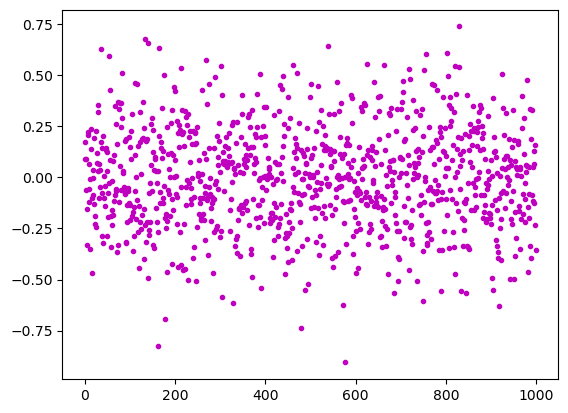

In [8]:
for lcv in range(1000):
    x = np.random.uniform(-1, 1)
    x_norm = (np.random.randn() + 0) / (4) * 1
    x2 = np.random.randn()
    # plt.plot(lcv,x,'r.')
    # plt.plot(lcv,x2,'k.')
    plt.plot(lcv,x_norm,'m.')

In [6]:
ca.__version__

'3.5.5'